In [113]:
from collections import Counter

import pandas as pd
import seaborn as sns
import scipy.stats as st
from nltk import word_tokenize
import numpy as np
import re
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm, trange

In [30]:
cluster = LocalCluster(n_workers=16)
client = Client(cluster)

In [3]:
candidate_sentences = pd.read_csv("candidate_sentences-gpt2-annotated.csv", index_col=0)

In [4]:
# Drop manually excluded
candidate_sentences = candidate_sentences[candidate_sentences["JG exclude"].isna()]

In [5]:
# only retain words+sentences which have >= 1 sentence for high and low labels
print(candidate_sentences.groupby("target_word").ngroups)
candidate_sentences = candidate_sentences.groupby(["target_word"]).filter(lambda x: x["label"].nunique() == 2)
print(candidate_sentences.groupby("target_word").ngroups)

129
106


In [6]:
candidate_sentences["sentence_length"] = candidate_sentences.sentence.apply(lambda x: len([x for x in word_tokenize(x) if not re.match(r'\W+', x)]))

In [193]:
words = pd.read_csv("adopted_df_blocks_withBalancedUnion.csv").set_index("word_us")

In [194]:
# Retain only those covered by the sentences
print(len(words))
words = words.loc[candidate_sentences["target_word"].unique()]
print(len(words))
words

132
106


,word_length,ortho_n_dens_s,ortho_n_freq_s_m,ortho_n_freq_s_sd,ortho_upoint,old20_m,old20_sd,sum_bigram,n_phon,n_syll,...,snd_arc,aff_val_m,aff_val_sd,aff_arou_m,aff_arou_sd,aff_dom_m,aff_dom_sd,Unnamed: 30,COND,block
word_us,,,,,,,,,,,,,,,,,,,,,
angle,5,1,2.612784,NaN,6,1.65,0.489360,0.022517,5,2,...,0.611150,4.55,1.28,3.22,2.24,5.27,1.83,NaN,O+P-,4
area,4,3,1.414313,0.874882,4,1.75,0.444262,0.035175,4,3,...,0.677775,5.56,1.29,2.19,1.60,5.06,1.76,NaN,O-P-,1
baby,4,1,3.258877,NaN,5,1.90,0.307794,0.015180,4,2,...,0.647788,6.67,2.36,4.97,2.65,4.94,2.87,NaN,O-P-,4
bait,4,4,2.487701,1.650007,4,1.70,0.470162,0.026305,3,1,...,0.514355,4.00,1.83,3.50,2.02,5.95,2.32,NaN,O-P+,2
beach,5,7,2.384041,0.929191,6,1.50,0.512989,0.047662,3,1,...,0.658304,7.21,1.51,5.10,2.23,5.70,2.33,NaN,O+P+,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind,4,11,3.039627,1.145753,5,1.35,0.489360,0.032707,4,1,...,0.651939,5.67,2.22,3.70,2.47,4.50,2.36,NaN,O+P+,3
wish,4,7,2.958385,1.461394,5,1.60,0.502625,0.029318,3,1,...,0.637178,7.14,1.77,3.38,2.33,6.50,2.33,NaN,O+P+,4
wood,4,7,3.371046,1.074693,5,1.50,0.512989,0.019520,3,1,...,0.667203,5.82,1.47,3.50,1.70,6.37,2.71,NaN,O+P+,3


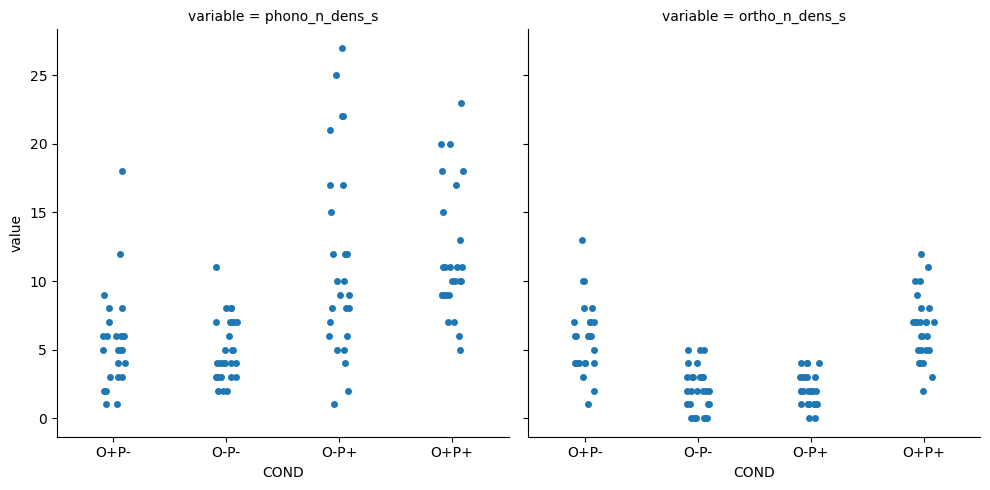

In [195]:
sns.catplot(data=words[["COND", "phono_n_dens_s", "ortho_n_dens_s"]].melt(id_vars=["COND"]), x="COND", y="value", col="variable")

In [196]:
# # drop low-PND outliers in P+ conditions
# words = words.loc[~words.index.isin(words[(words.COND == "O-P+") & (words.phono_n_dens_s < 5)].index)]
to_drop = words[((words.COND == "O-P+") & (words.phono_n_dens_s <= 5)) |
                ((words.COND == "O+P+") & (words.phono_n_dens_s <= 5))].index
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]

Index(['duty', 'earth', 'feud', 'floor', 'frame', 'plane'], dtype='object', name='word_us')


In [197]:
# drop low-OND outliers in O+ condition
to_drop = words[(words.COND == "O+P-") & (words.ortho_n_dens_s <= 2)].index
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]

Index(['angle', 'dream'], dtype='object', name='word_us')


In [198]:
# drop high-PND outliers in P- conditions
to_drop = words[((words.COND == "O+P-") & (words.phono_n_dens_s > 10)) |
                ((words.COND == "O-P-") & (words.phono_n_dens_s > 10))].index
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]
print(len(words))

Index(['chief', 'chin', 'joke'], dtype='object', name='word_us')
95


In [199]:
# drop high-OND outliers in O- conditions
to_drop = words[(words.COND == "O-P-") & (words.ortho_n_dens_s > 4)].index
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]
print(len(words))

Index(['bench', 'gift', 'shirt'], dtype='object', name='word_us')
92


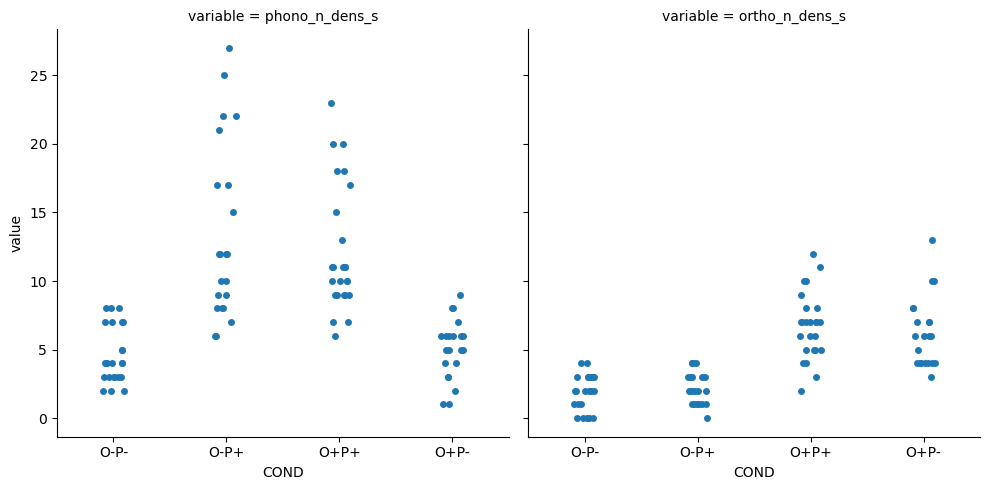

In [200]:
sns.catplot(data=words[["COND", "phono_n_dens_s", "ortho_n_dens_s"]].melt(id_vars=["COND"]), x="COND", y="value", col="variable")

## Rejection sampling method

In [201]:
merged = pd.merge(candidate_sentences, words, left_on="target_word", right_on="word_us")
merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())

/tmp/ipykernel_3253868/1251679934.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())


COND
O+P+    25
O+P-    21
O-P+    22
O-P-    24
dtype: int64

In [214]:
# target number of words per condition (OND*PND*surprisal)
word_sample_size = 16

num_blocks = 4
# each of these unions of blocks should respect statistical tests within-union
candidate_blocks = [[0], [1], [2], [3], [0, 1], [2, 3], [0, 1, 2, 3]]
# each of these pairs of block unions should respect cross-modality tests
candidate_block_pairs = [([0], [2]), ([0, 1], [2, 3])]

# we want to maximize differences in these variables between conditions
max_variables = ["surprisal", "ortho_n_dens_s", "phono_n_dens_s"]
# we want to minimize differences in these variables between conditions
min_variables = ["word_length", "n_phon", "n_syll", "sum_bigram", "sum_biphone",
                 "lgsubtlwf", "concrete_m", "aff_val_m", "aff_arou_m",
                 "sentence_length", "entropy"]

def get_sample():
    s_words = words.groupby("COND").sample(word_sample_size, replace=False)
    # sample 1 context sentence per word+context condition
    s_sentences = pd.merge(candidate_sentences, s_words, left_on="target_word", right_on="word_us").groupby(["target_word", "label"]).sample(1)
    s_sentences["our_cond"] = s_sentences.COND + " " + s_sentences.label

    cv = StratifiedKFold(num_blocks, shuffle=True).split(s_sentences, s_sentences.our_cond)
    s_sentences = pd.concat([s_sentences.iloc[idxs].drop(columns=["block"]) for _, idxs in cv],
                            keys=range(num_blocks), names=["block"])

    s_melted = s_sentences.reset_index().melt(
        id_vars=["block", "target_word", "label", "COND", "our_cond", "sentence"],
        value_vars=["surprisal", "entropy", "word_length", "ortho_n_dens_s",
                    "ortho_n_freq_s_m", "ortho_upoint", "old20_m",
                    "sum_bigram", "n_phon", "n_syll", "phono_n_dens_s",
                    "phono_n_freq_s_m", "phono_upoint", "pld20_m",
                    "sum_biphone", "lgsubtlwf", "concrete_m",
                    "aff_val_m", "aff_arou_m", "sentence_length"])

    return s_words, s_sentences, s_melted

def get_stats(melted_df):
    ret = []
    for block_union in candidate_blocks:
        study_df = melted_df.loc[melted_df.block.isin(block_union)]
        ret.append(study_df.groupby("variable").apply(lambda x:
            pd.Series(st.f_oneway(*[x.loc[x.our_cond == cond, "value"] for cond in x.our_cond.unique()]),
                      index=["F", "p"]), include_groups=False))
    return pd.concat(ret, keys=range(len(candidate_blocks)), names=["block_union"]) \
        .reorder_levels(["variable", "block_union"])

def objective(sentence_df, melted_df, alpha=0.01, verbose=False):
    assert sentence_df.index.names[0] == "block"

    ############ dataset-wide tests
    # First ensure that the relevant condition t-tests pass across the whole set
    # we expect differences in the relevant target variables between these conds
    target_positive_tests = [("ortho_n_dens_s", "COND", "O+P+", "O-P+"),
                             ("ortho_n_dens_s", "COND", "O+P-", "O-P-"),
                             ("ortho_n_dens_s", "COND", "O-P-", "O+P+"),
                             ("phono_n_dens_s", "COND", "O+P+", "O+P-"),
                             ("phono_n_dens_s", "COND", "O-P+", "O-P-"),
                             ("phono_n_dens_s", "COND", "O-P-", "O+P+"),
                             ("surprisal", "label", "high", "low")]
    for test_spec in target_positive_tests:
        var, grouping_variable, group1, group2 = test_spec
        sentence_df_ = sentence_df.set_index(grouping_variable)
        ttest_t, ttest_p = st.ttest_ind(sentence_df_.loc[group1, var], sentence_df_.loc[group2, var])
        if ttest_p > alpha:
            if verbose:
                print(f"failed positive t-test for {var} between {group1} and {group2}")
            return -np.inf, ("positive_t", test_spec)
            
    # we expect no significant differences in these variables between these conds
    target_null_tests = [("ortho_n_dens_s", "COND", "O+P+", "O+P-"),
                         ("ortho_n_dens_s", "COND", "O-P+", "O-P-"),
                         ("phono_n_dens_s", "COND", "O+P-", "O-P-"),
                         ("phono_n_dens_s", "COND", "O+P+", "O-P+"),]
    for test_spec in target_null_tests:
        var, grouping_variable, group1, group2 = test_spec
        sentence_df_ = sentence_df.set_index(grouping_variable)
        ttest_t, ttest_p = st.ttest_ind(sentence_df_.loc[group1, var], sentence_df_.loc[group2, var])
        if ttest_p < alpha:
            if verbose:
                print(f"failed null t-test for {var} between {group1} and {group2}")
            return -np.inf, ("null_t", test_spec)
        

    ######### block-level tests
    # we expect no significant differences in these variables within these cond levels between-block
    target_null_between_tests = [("ortho_n_dens_s", "COND", ("O+P+", "O+P-")),
                                 ("ortho_n_dens_s", "COND", ("O-P+", "O-P-")),
                                 ("phono_n_dens_s", "COND", ("O+P-", "O-P-")),
                                 ("phono_n_dens_s", "COND", ("O+P+", "O-P+"))]
    
    # first ensure that the previous dataset-wide tests also pass on all possible incremental
    # data collection outcomes
    for block_union in candidate_blocks:
        study_df = sentence_df.loc[block_union]
        for test_spec in target_positive_tests:
            var, grouping_variable, group1, group2 = test_spec
            study_df_ = study_df.set_index(grouping_variable)
            ttest_t, ttest_p = st.ttest_ind(study_df_.loc[group1, var], study_df_.loc[group2, var])
            if ttest_p > alpha:
                if verbose:
                    print(f"Block union {block_union} failed t-test for {var} between {group1} and {group2}")
                return -np.inf, ("block_positive_t", test_spec)

        for test_spec in target_null_tests:
            var, grouping_variable, group1, group2 = test_spec
            study_df_ = study_df.set_index(grouping_variable)
            ttest_t, ttest_p = st.ttest_ind(study_df_.loc[group1, var], study_df_.loc[group2, var])
            if ttest_p < alpha:
                if verbose:
                    print(f"Block union {block_union} failed t-test for {var} between {group1} and {group2}")
                return -np.inf, ("block_null_t", test_spec)
            
    # now ensure that concepts like "O+" and "P-" mean the same thing across
    # two testing modalities (blocks 0, 1 listening; 2, 3 reading)
    for union1, union2 in candidate_block_pairs:
        study_df1 = sentence_df.loc[union1]
        study_df2 = sentence_df.loc[union2]
        for test_spec in target_null_between_tests:
            var, grouping_variable, groups = test_spec
            study_df1_ = study_df1.set_index(grouping_variable)
            study_df2_ = study_df2.set_index(grouping_variable)
            ftest_F, ftest_p = st.f_oneway(*([study_df1_.loc[group, var] for group in groups] +
                                             [study_df2_.loc[group, var] for group in groups]))
            if ftest_p < alpha:
                if verbose:
                    print(f"Block union {union1} vs {union2} failed F-test for {var} between {groups}")
                return -np.inf, ("block_between_f", test_spec)

    ######### F test
    # Constraints above all passed; just rank the stimulus set by F value
    results = get_stats(melted_df)

    # max_p = results.loc[max_variables, "p"].min()
    min_p = results.loc[min_variables, "p"].min()

    # it's easy to maximize the max variables -- let's focus on the min variables
    # return max_diff - min_diff
    
    return min_p, None

In [215]:
@delayed
def sample_and_evaluate():
    s_words, s_sentences, s_melted = get_sample()
    obj, sentinel = objective(s_sentences, s_melted)
    return obj, sentinel, (s_words, s_sentences, s_melted)

In [231]:
# Create a list of delayed evaluation tasks
tasks = [sample_and_evaluate() for i in range(100000)]

# Compute all tasks in parallel
with ProgressBar():
    results = compute(*tasks, scheduler="processes")

# Extract the best sample and objective value
failure_causes = Counter()
best_objective = float("-inf")
best_sample = None

for i, (obj, sentinel, sample) in enumerate(results):
    failure_causes[sentinel] += 1
    if obj > best_objective:
        print(i, obj)
        best_objective = obj
        best_sample = sample

/home/jgauthier/u/transformers/lib/python3.10/site-packages/dask/base.py:1487: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


[                                        ] | 0% Completed | 46.98 sms

IOStream.flush timed out


[                                        ] | 0% Completed | 52.43 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 0% Completed | 53.45 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 0% Completed | 55.00 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 0% Completed | 57.84 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 1% Completed | 66.21 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 1% Completed | 68.02 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 1% Completed | 69.79 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 1% Completed | 70.96 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 2% Completed | 73.57 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 2% Completed | 76.28 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[                                        ] | 2% Completed | 77.18 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 2% Completed | 80.21 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 2% Completed | 81.91 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 3% Completed | 85.74 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 3% Completed | 87.20 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#                                       ] | 4% Completed | 96.64 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 4% Completed | 99.21 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 4% Completed | 100.87 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 5% Completed | 113.46 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 6% Completed | 119.77 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 6% Completed | 124.84 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 7% Completed | 127.13 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 7% Completed | 127.58 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 7% Completed | 131.94 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###                                     ] | 7% Completed | 134.00 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 8% Completed | 138.21 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###                                     ] | 8% Completed | 146.77 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 9% Completed | 148.20 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 9% Completed | 152.29 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###                                     ] | 9% Completed | 158.90 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 11% Completed | 173.38 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 11% Completed | 173.81 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 11% Completed | 176.39 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 11% Completed | 179.85 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 12% Completed | 181.09 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####                                   ] | 12% Completed | 185.37 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####                                   ] | 13% Completed | 191.30 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####                                   ] | 13% Completed | 191.63 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####                                   ] | 14% Completed | 209.00 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####                                   ] | 14% Completed | 211.11 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 15% Completed | 218.40 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 15% Completed | 218.86 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 15% Completed | 221.81 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 15% Completed | 223.30 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[######                                  ] | 16% Completed | 226.90 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[######                                  ] | 16% Completed | 229.64 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 17% Completed | 238.40 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 17% Completed | 239.61 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 18% Completed | 251.85 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 18% Completed | 252.74 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 19% Completed | 256.44 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 19% Completed | 257.24 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[########                                ] | 20% Completed | 266.39 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[########                                ] | 20% Completed | 268.17 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########                                ] | 21% Completed | 283.75 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########                                ] | 21% Completed | 287.89 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 22% Completed | 296.91 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 23% Completed | 299.99 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#########                               ] | 23% Completed | 303.83 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 23% Completed | 305.95 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 24% Completed | 310.28 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#########                               ] | 24% Completed | 310.53 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 24% Completed | 311.73 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########                              ] | 25% Completed | 326.80 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########                              ] | 25% Completed | 328.58 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 27% Completed | 348.03 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 27% Completed | 349.38 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 28% Completed | 351.07 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 28% Completed | 353.32 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 28% Completed | 355.49 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 29% Completed | 370.49 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 29% Completed | 373.28 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############                            ] | 30% Completed | 384.66 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############                            ] | 30% Completed | 385.00 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############                            ] | 31% Completed | 396.69 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############                           ] | 32% Completed | 404.96 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############                           ] | 33% Completed | 415.45 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############                           ] | 34% Completed | 424.03 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############                          ] | 35% Completed | 429.77 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##############                          ] | 35% Completed | 436.45 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############                          ] | 35% Completed | 437.02 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##############                          ] | 36% Completed | 441.79 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############                          ] | 37% Completed | 448.77 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############                          ] | 37% Completed | 449.36 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 38% Completed | 473.85 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 39% Completed | 475.64 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 39% Completed | 478.62 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 39% Completed | 483.62 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 40% Completed | 487.82 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[################                        ] | 41% Completed | 495.81 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 41% Completed | 499.91 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[################                        ] | 41% Completed | 503.01 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 42% Completed | 507.87 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 42% Completed | 509.65 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 42% Completed | 510.32 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 516.21 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 520.12 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 44% Completed | 531.16 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 45% Completed | 536.29 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 46% Completed | 546.65 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 46% Completed | 547.56 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 46% Completed | 550.05 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 48% Completed | 568.39 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 48% Completed | 572.74 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 48% Completed | 573.07 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 49% Completed | 578.73 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 50% Completed | 10m 1s s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 51% Completed | 10m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 51% Completed | 10m 8s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 51% Completed | 10m 11s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 52% Completed | 10m 17s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 52% Completed | 10m 19s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 53% Completed | 10m 25s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 53% Completed | 10m 30s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 54% Completed | 10m 35s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 54% Completed | 10m 37s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 55% Completed | 10m 45s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 55% Completed | 10m 45s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 55% Completed | 10m 49s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 56% Completed | 10m 51s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[######################                  ] | 56% Completed | 10m 53s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 56% Completed | 10m 56s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 56% Completed | 10m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 56% Completed | 10m 58s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 56% Completed | 11m 0ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 57% Completed | 11m 3s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[######################                  ] | 57% Completed | 11m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 57% Completed | 11m 7s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 58% Completed | 11m 13s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 58% Completed | 11m 15s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 58% Completed | 11m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 58% Completed | 11m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 58% Completed | 11m 19s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 58% Completed | 11m 21s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######################                 ] | 59% Completed | 11m 22s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########################                ] | 60% Completed | 11m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 62% Completed | 11m 58s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 63% Completed | 12m 2ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 63% Completed | 12m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#########################               ] | 63% Completed | 12m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 63% Completed | 12m 6s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#########################               ] | 63% Completed | 12m 9s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 64% Completed | 12m 11s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 64% Completed | 12m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 64% Completed | 12m 17s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 64% Completed | 12m 20s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 65% Completed | 12m 38s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 66% Completed | 12m 44s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 66% Completed | 12m 46s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 67% Completed | 12m 52s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 67% Completed | 12m 56s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 67% Completed | 12m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 67% Completed | 12m 59s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 68% Completed | 13m 1ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 68% Completed | 13m 3s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 68% Completed | 13m 4s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 68% Completed | 13m 9s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 69% Completed | 13m 18s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###########################             ] | 69% Completed | 13m 19s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 70% Completed | 13m 26s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 71% Completed | 13m 33s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 71% Completed | 13m 40s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 72% Completed | 13m 43s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 73% Completed | 13m 54s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 73% Completed | 13m 56s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 74% Completed | 14m 3ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 74% Completed | 14m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 75% Completed | 14m 11s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 75% Completed | 14m 15s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 75% Completed | 14m 17s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 76% Completed | 14m 22s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##############################          ] | 76% Completed | 14m 23s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 76% Completed | 14m 31s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 77% Completed | 14m 40s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 77% Completed | 14m 41s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 78% Completed | 14m 42s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 79% Completed | 14m 52s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 80% Completed | 15m 6ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 80% Completed | 15m 7s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 80% Completed | 15m 11s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 81% Completed | 15m 13s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 81% Completed | 15m 15s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 81% Completed | 15m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 82% Completed | 15m 25s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################################       ] | 82% Completed | 15m 29s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################################       ] | 84% Completed | 15m 58s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################################       ] | 84% Completed | 16m 4ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################################       ] | 84% Completed | 16m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 85% Completed | 16m 11s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 85% Completed | 16m 14s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 85% Completed | 16m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##################################      ] | 86% Completed | 16m 18s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 86% Completed | 16m 19s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 86% Completed | 16m 22s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 86% Completed | 16m 24s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################################     ] | 87% Completed | 16m 33s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###################################     ] | 88% Completed | 16m 37s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################################     ] | 88% Completed | 16m 40s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################################     ] | 88% Completed | 16m 41s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###################################     ] | 89% Completed | 16m 50s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###################################     ] | 89% Completed | 16m 54s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################    ] | 90% Completed | 16m 58s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[####################################    ] | 91% Completed | 17m 9ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################    ] | 92% Completed | 17m 18s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################    ] | 92% Completed | 17m 20s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 93% Completed | 17m 28s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 93% Completed | 17m 31s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 94% Completed | 17m 41s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################################   ] | 94% Completed | 17m 48s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################################  ] | 95% Completed | 17m 49s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################################  ] | 95% Completed | 17m 52s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################################  ] | 96% Completed | 18m 1ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################################  ] | 96% Completed | 18m 3s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################################  ] | 96% Completed | 18m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################### ] | 97% Completed | 18m 14s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################### ] | 99% Completed | 18m 32s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################### ] | 99% Completed | 18m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########################################] | 100% Completed | 18m 38s
0 0.0036412637319381746
608 0.006013079570318927
1259 0.007535244790742949
4197 0.009924774589383761
5836 0.010498487650700813
9806 0.01069919107170257
9960 0.017907489782326452
33622 0.0220892849010517
81125 0.03936412066193566


In [232]:
failure_causes.most_common()

[(('block_positive_t', ('phono_n_dens_s', 'COND', 'O-P+', 'O-P-')), 25891),
 (None, 19242),
 (('block_positive_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O+P-')), 14096),
 (('block_positive_t', ('ortho_n_dens_s', 'COND', 'O+P+', 'O-P+')), 8217),
 (('block_positive_t', ('ortho_n_dens_s', 'COND', 'O+P-', 'O-P-')), 5758),
 (('null_t', ('ortho_n_dens_s', 'COND', 'O-P+', 'O-P-')), 4365),
 (('block_null_t', ('phono_n_dens_s', 'COND', 'O+P-', 'O-P-')), 3808),
 (('block_null_t', ('ortho_n_dens_s', 'COND', 'O+P+', 'O+P-')), 3778),
 (('block_null_t', ('ortho_n_dens_s', 'COND', 'O-P+', 'O-P-')), 2824),
 (('null_t', ('ortho_n_dens_s', 'COND', 'O+P+', 'O+P-')), 2518),
 (('block_positive_t', ('phono_n_dens_s', 'COND', 'O-P-', 'O+P+')), 2164),
 (('null_t', ('phono_n_dens_s', 'COND', 'O+P-', 'O-P-')), 1924),
 (('block_null_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O-P+')), 1910),
 (('block_positive_t', ('ortho_n_dens_s', 'COND', 'O-P-', 'O+P+')), 1402),
 (('null_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O-P+

In [233]:
# sample id is a hash of the current timestamp
from time import time
from hashlib import sha1
sample_id = sha1(str(int(time())).encode()).hexdigest()[:8]
print(sample_id)

s_words, s_sentences, s_melted = best_sample
s_words.to_csv(f"{sample_id}-words.csv")
s_sentences.to_csv(f"{sample_id}-sentences.csv")
s_melted.to_csv(f"{sample_id}-melted.csv")

s_stats = get_stats(s_melted).sort_values("p")
s_stats.to_csv(f"{sample_id}-stats.csv")

33062e87


In [234]:
s_stats

F             p
variable         block_union                          
surprisal        6            453.456118  3.992743e-83
                 4            294.540664  9.085903e-42
                 5            220.385464  2.335184e-38
old20_m          6             28.184169  1.298620e-22
ortho_n_dens_s   6             24.378857  2.176819e-20
...                                  ...           ...
ortho_n_freq_s_m 2                   NaN           NaN
                 3                   NaN           NaN
                 4                   NaN           NaN
                 5                   NaN           NaN
                 6                   NaN           NaN

[140 rows x 2 columns]

## Marginal plots

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Target manipulations')

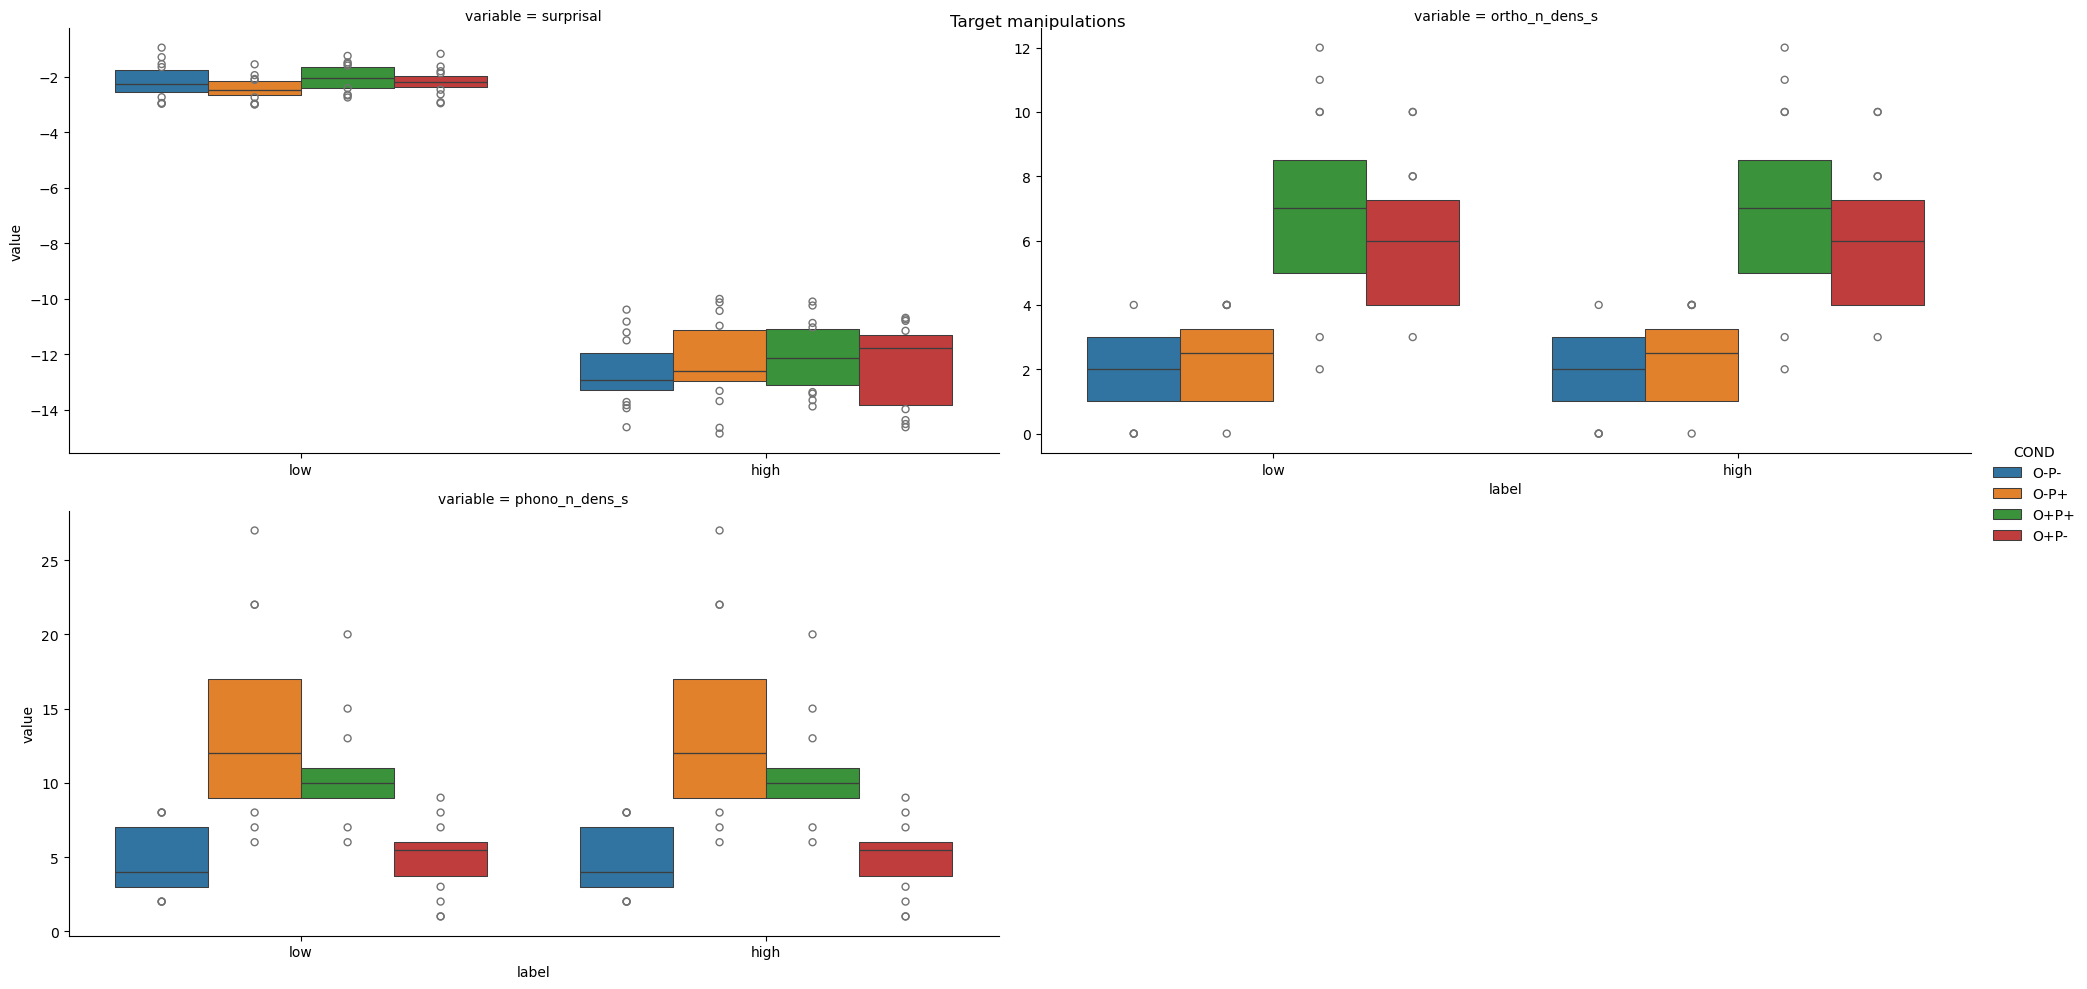

In [235]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(max_variables)],
                x="label", hue="COND", y="value", col="variable", col_wrap=2,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Target manipulations")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Aim to match between conditions')

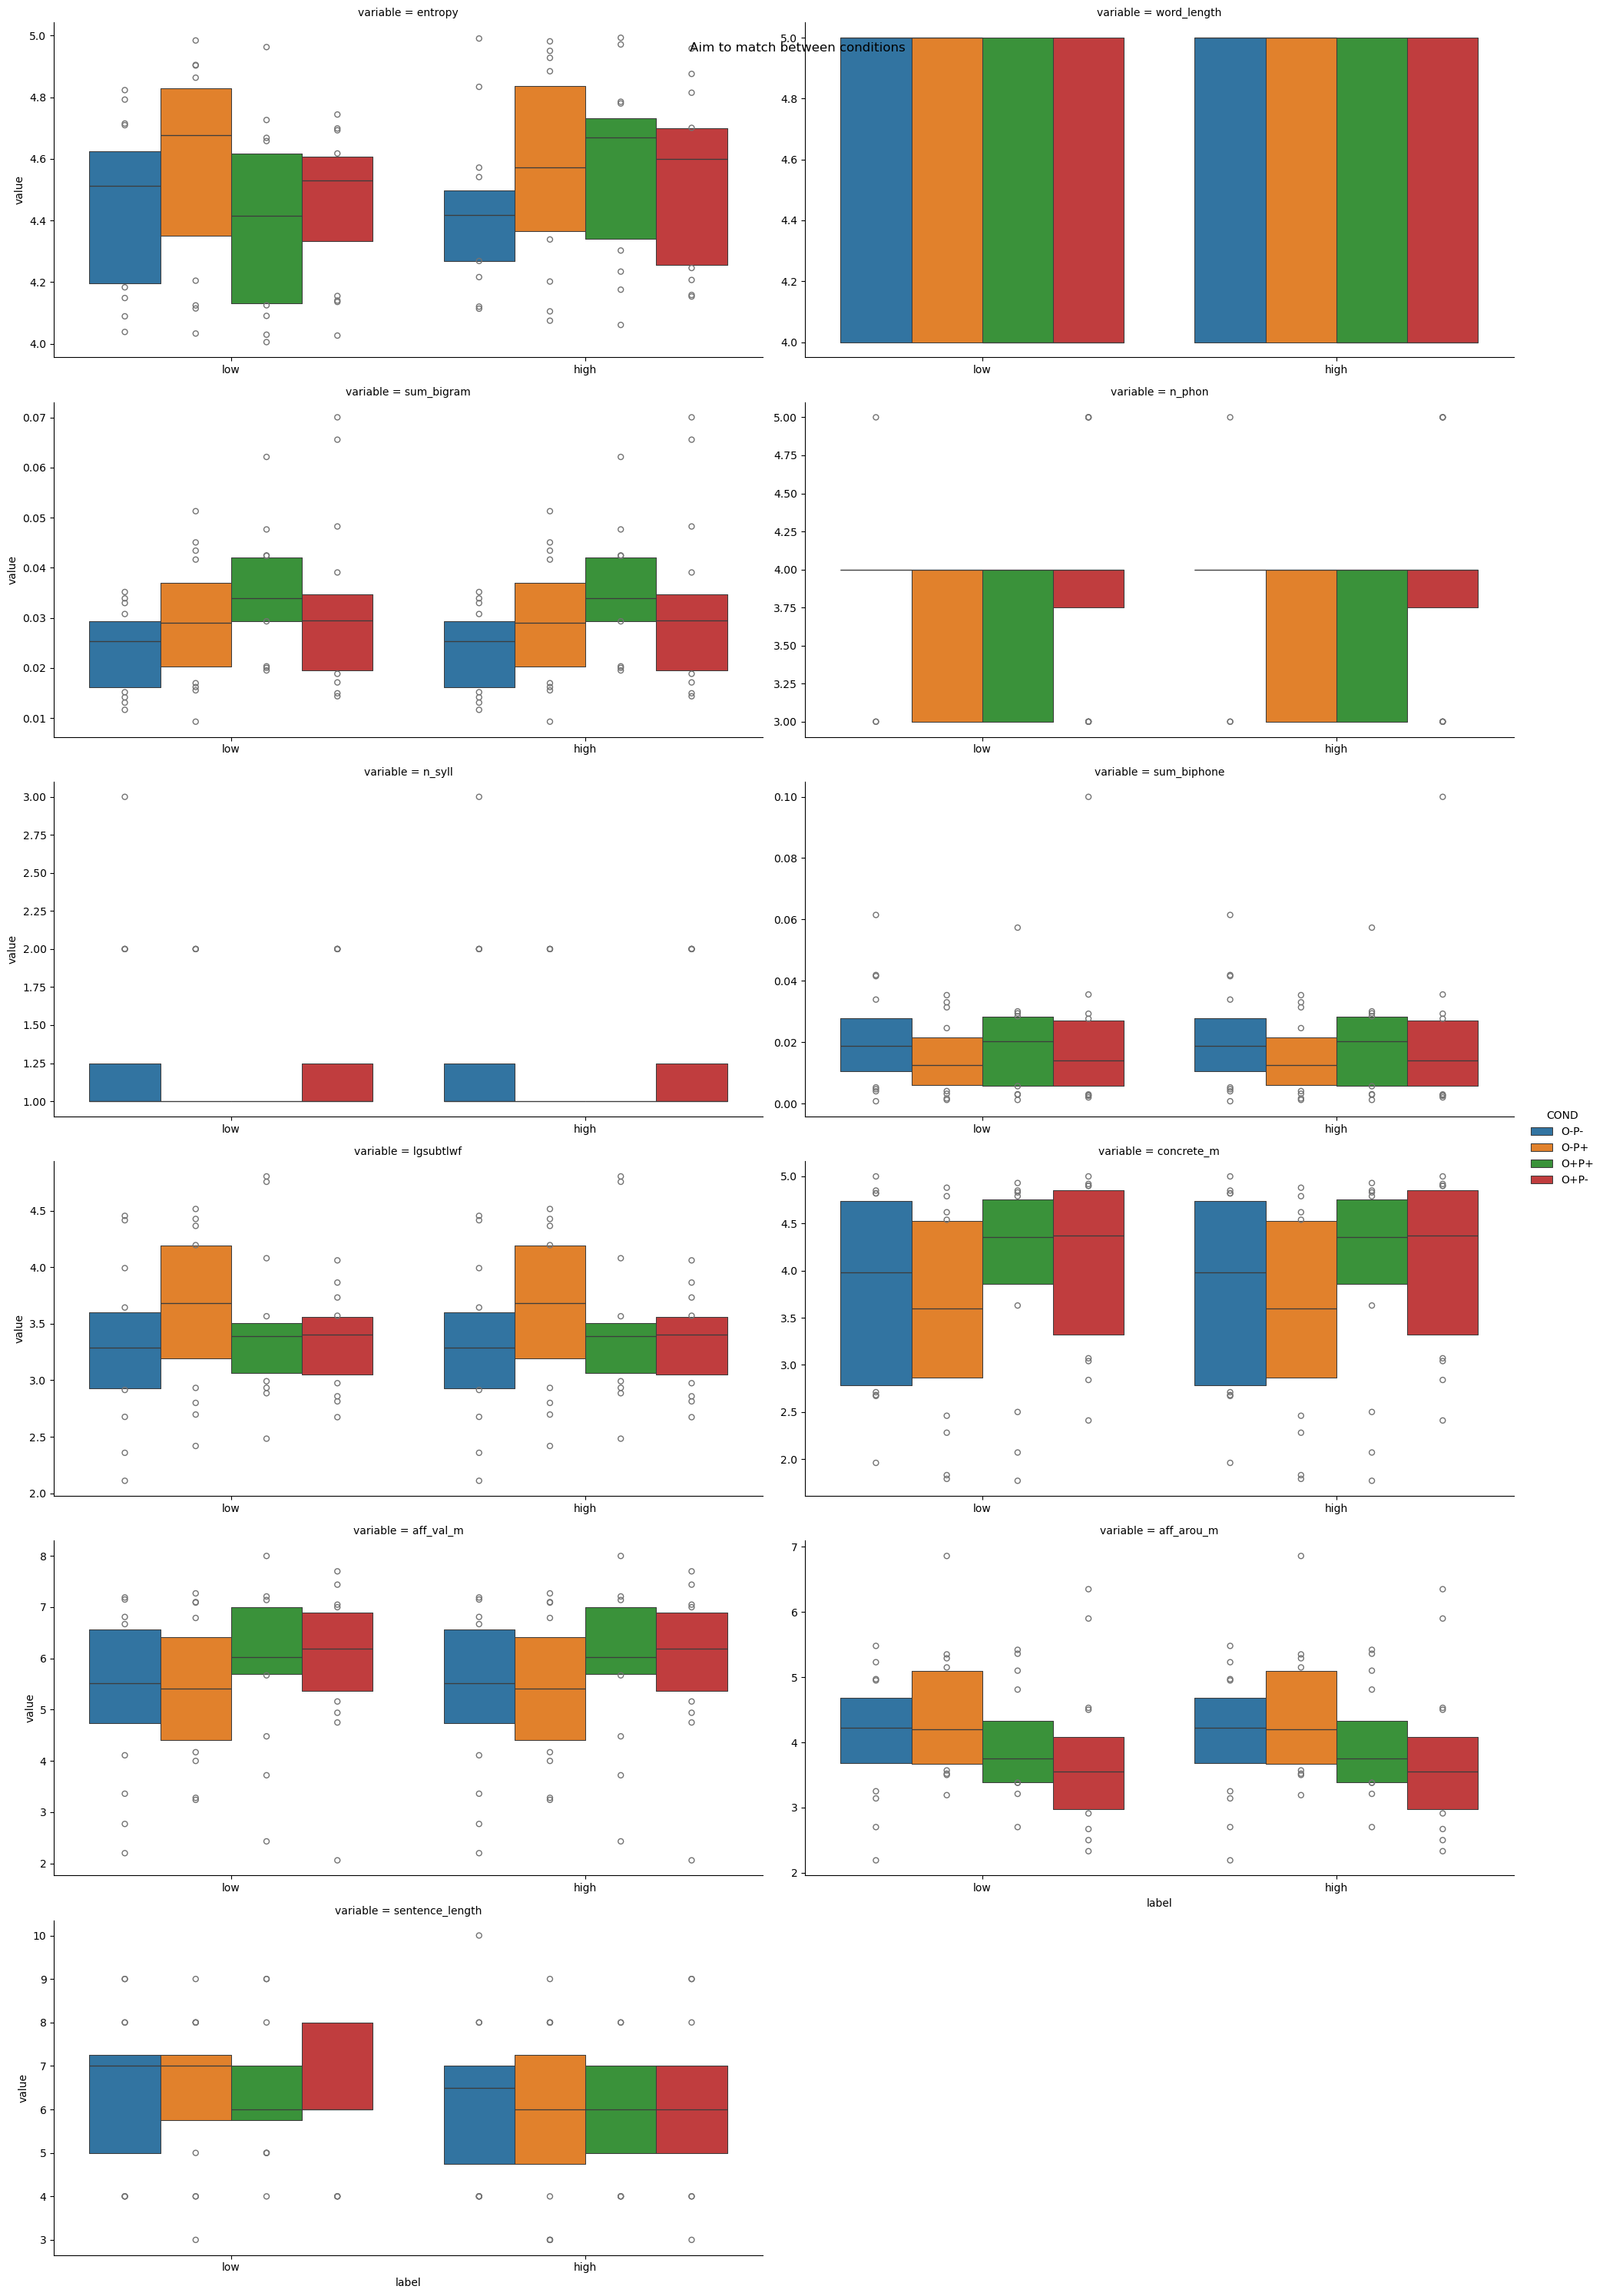

In [236]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(min_variables)],
                x="label", hue="COND", y="value", col="variable", col_wrap=2,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Aim to match between conditions")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Other stuff')

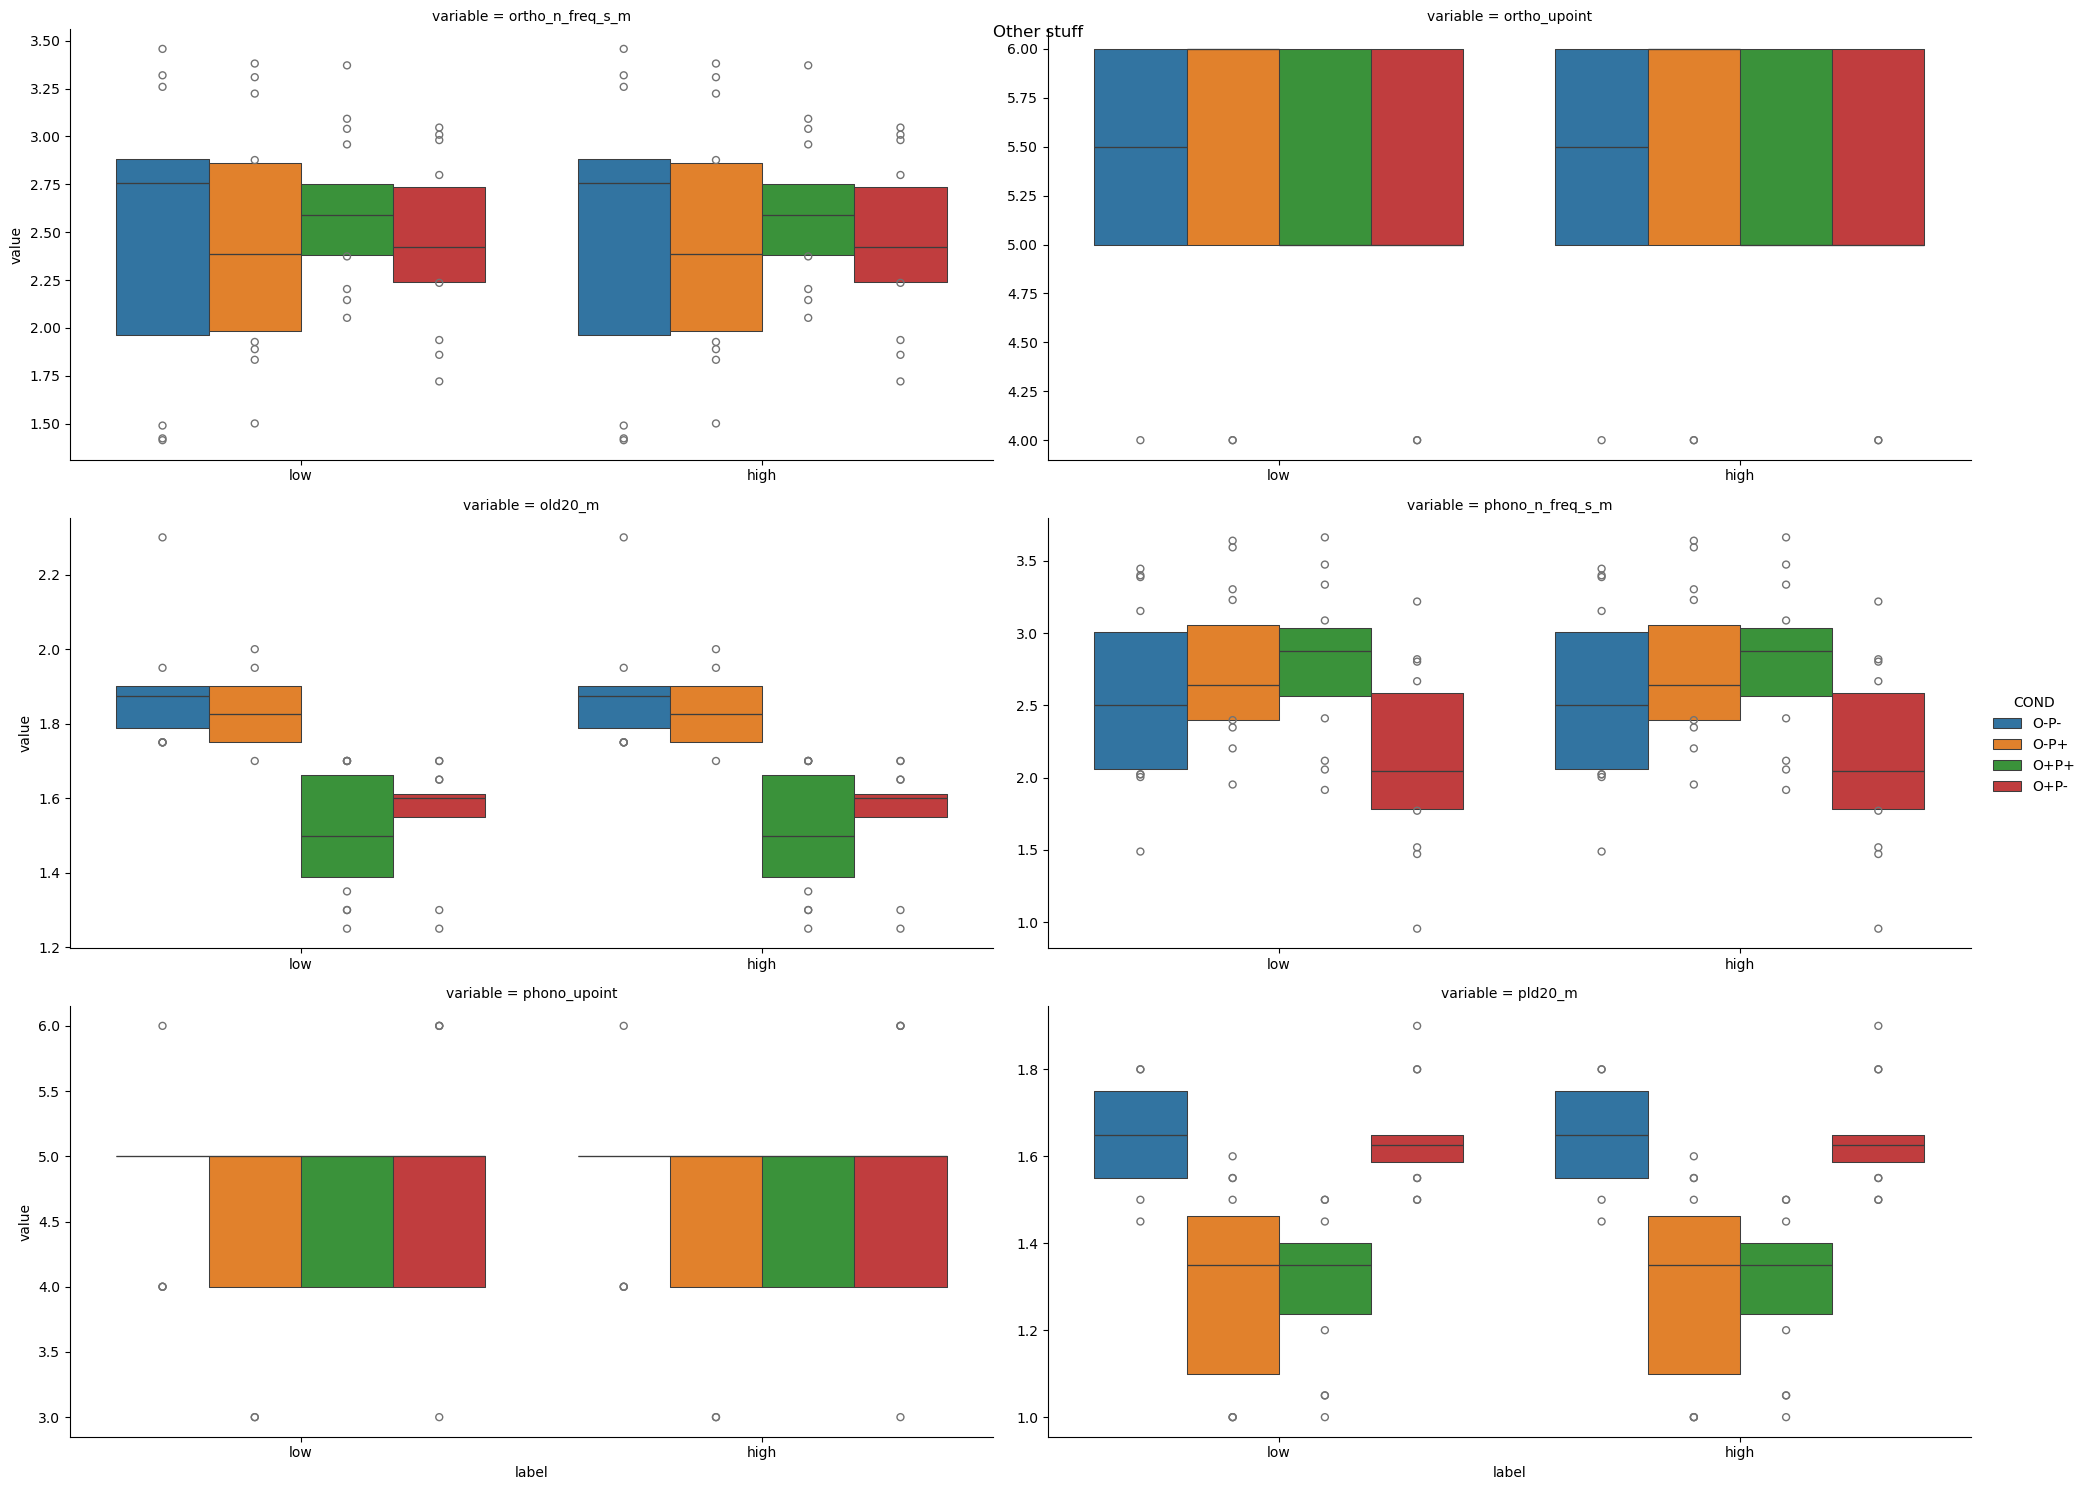

In [237]:
g = sns.catplot(data=s_melted[~s_melted.variable.isin(min_variables + max_variables)],
                x="label", hue="COND", y="value", col="variable", col_wrap=2,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Other stuff")

## Plots by block

Text(0.5, 0.98, 'Target manipulations')

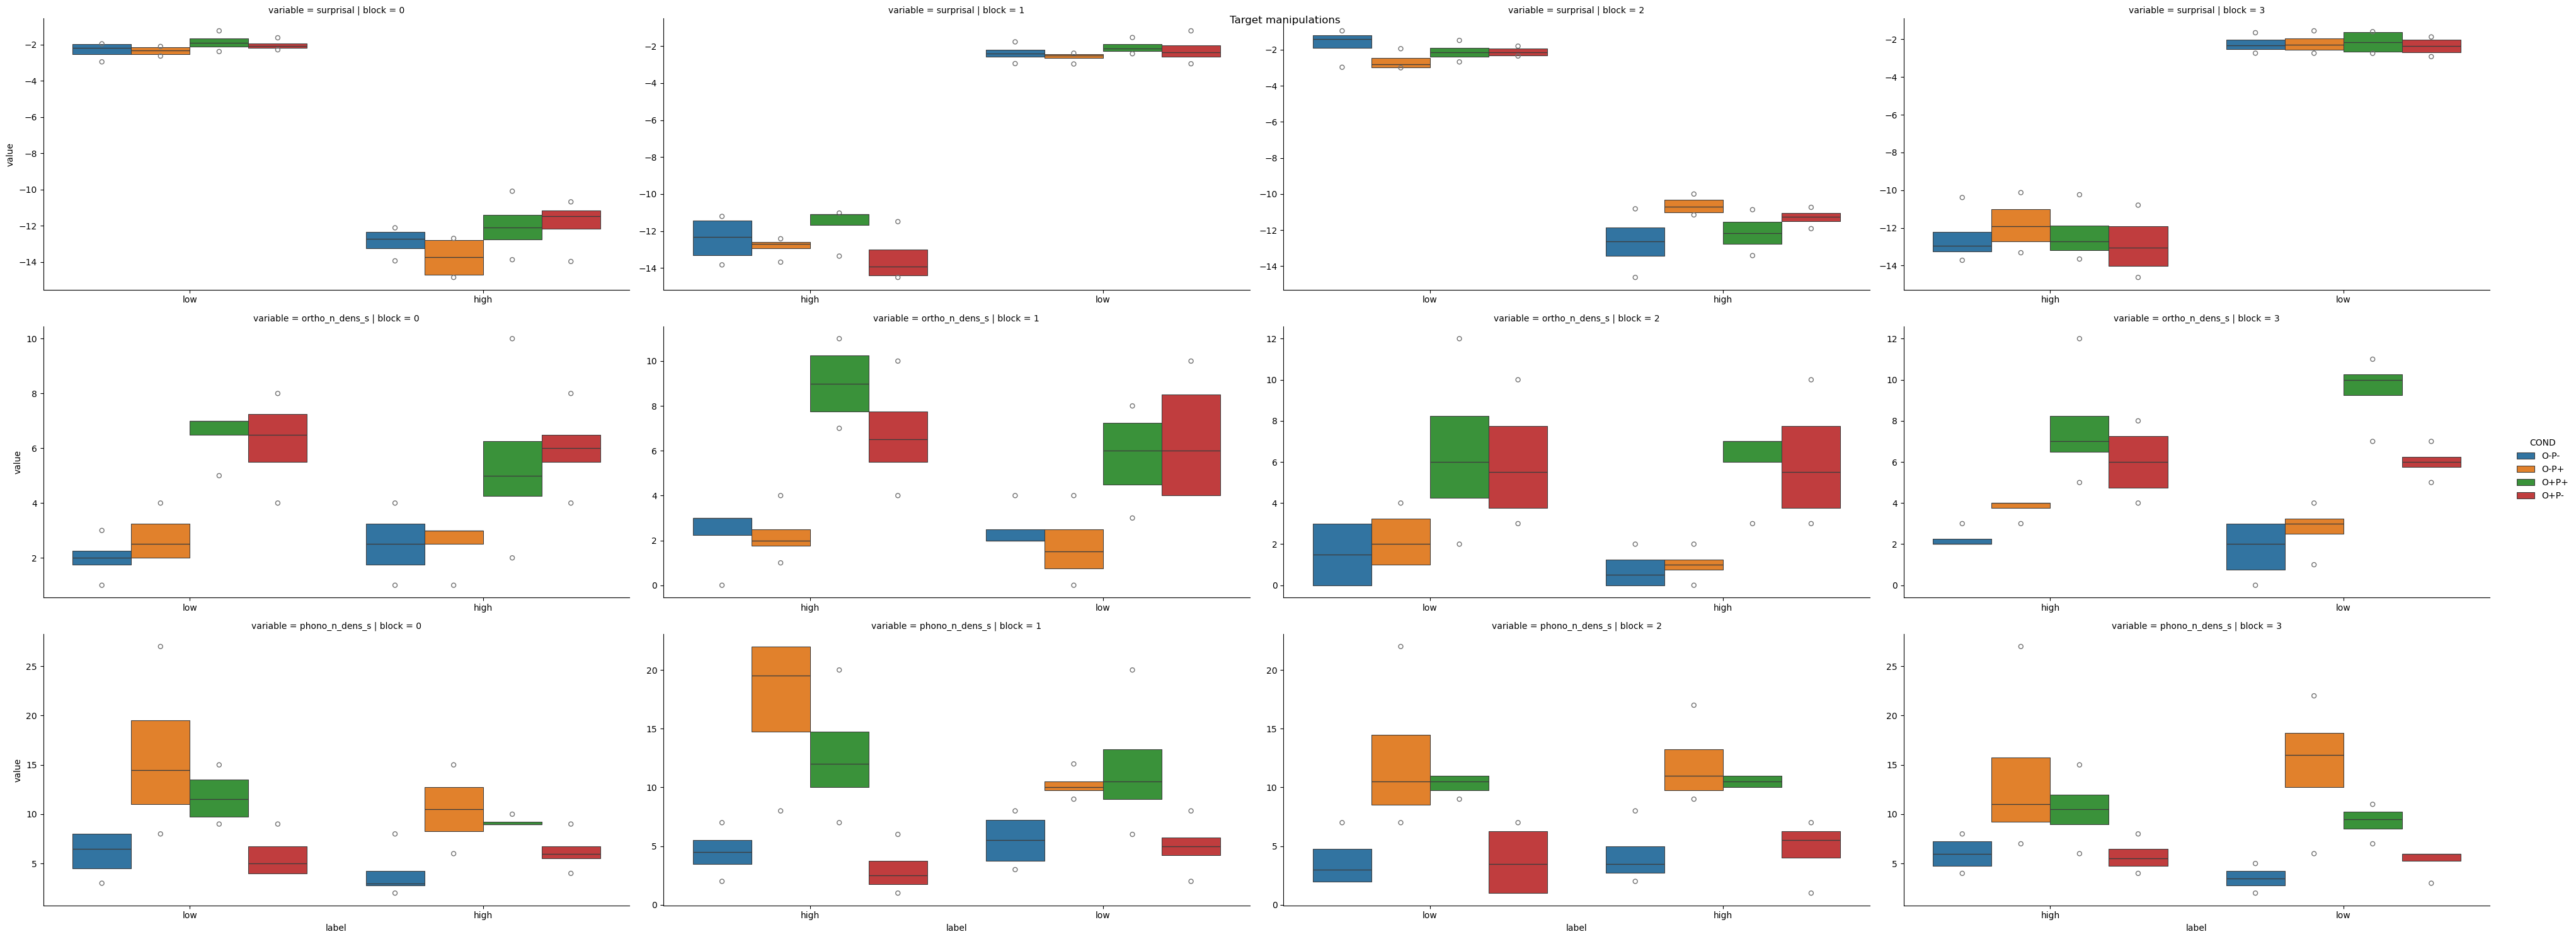

In [238]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(max_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Target manipulations")

Text(0.5, 0.98, 'Aim to match between conditions')

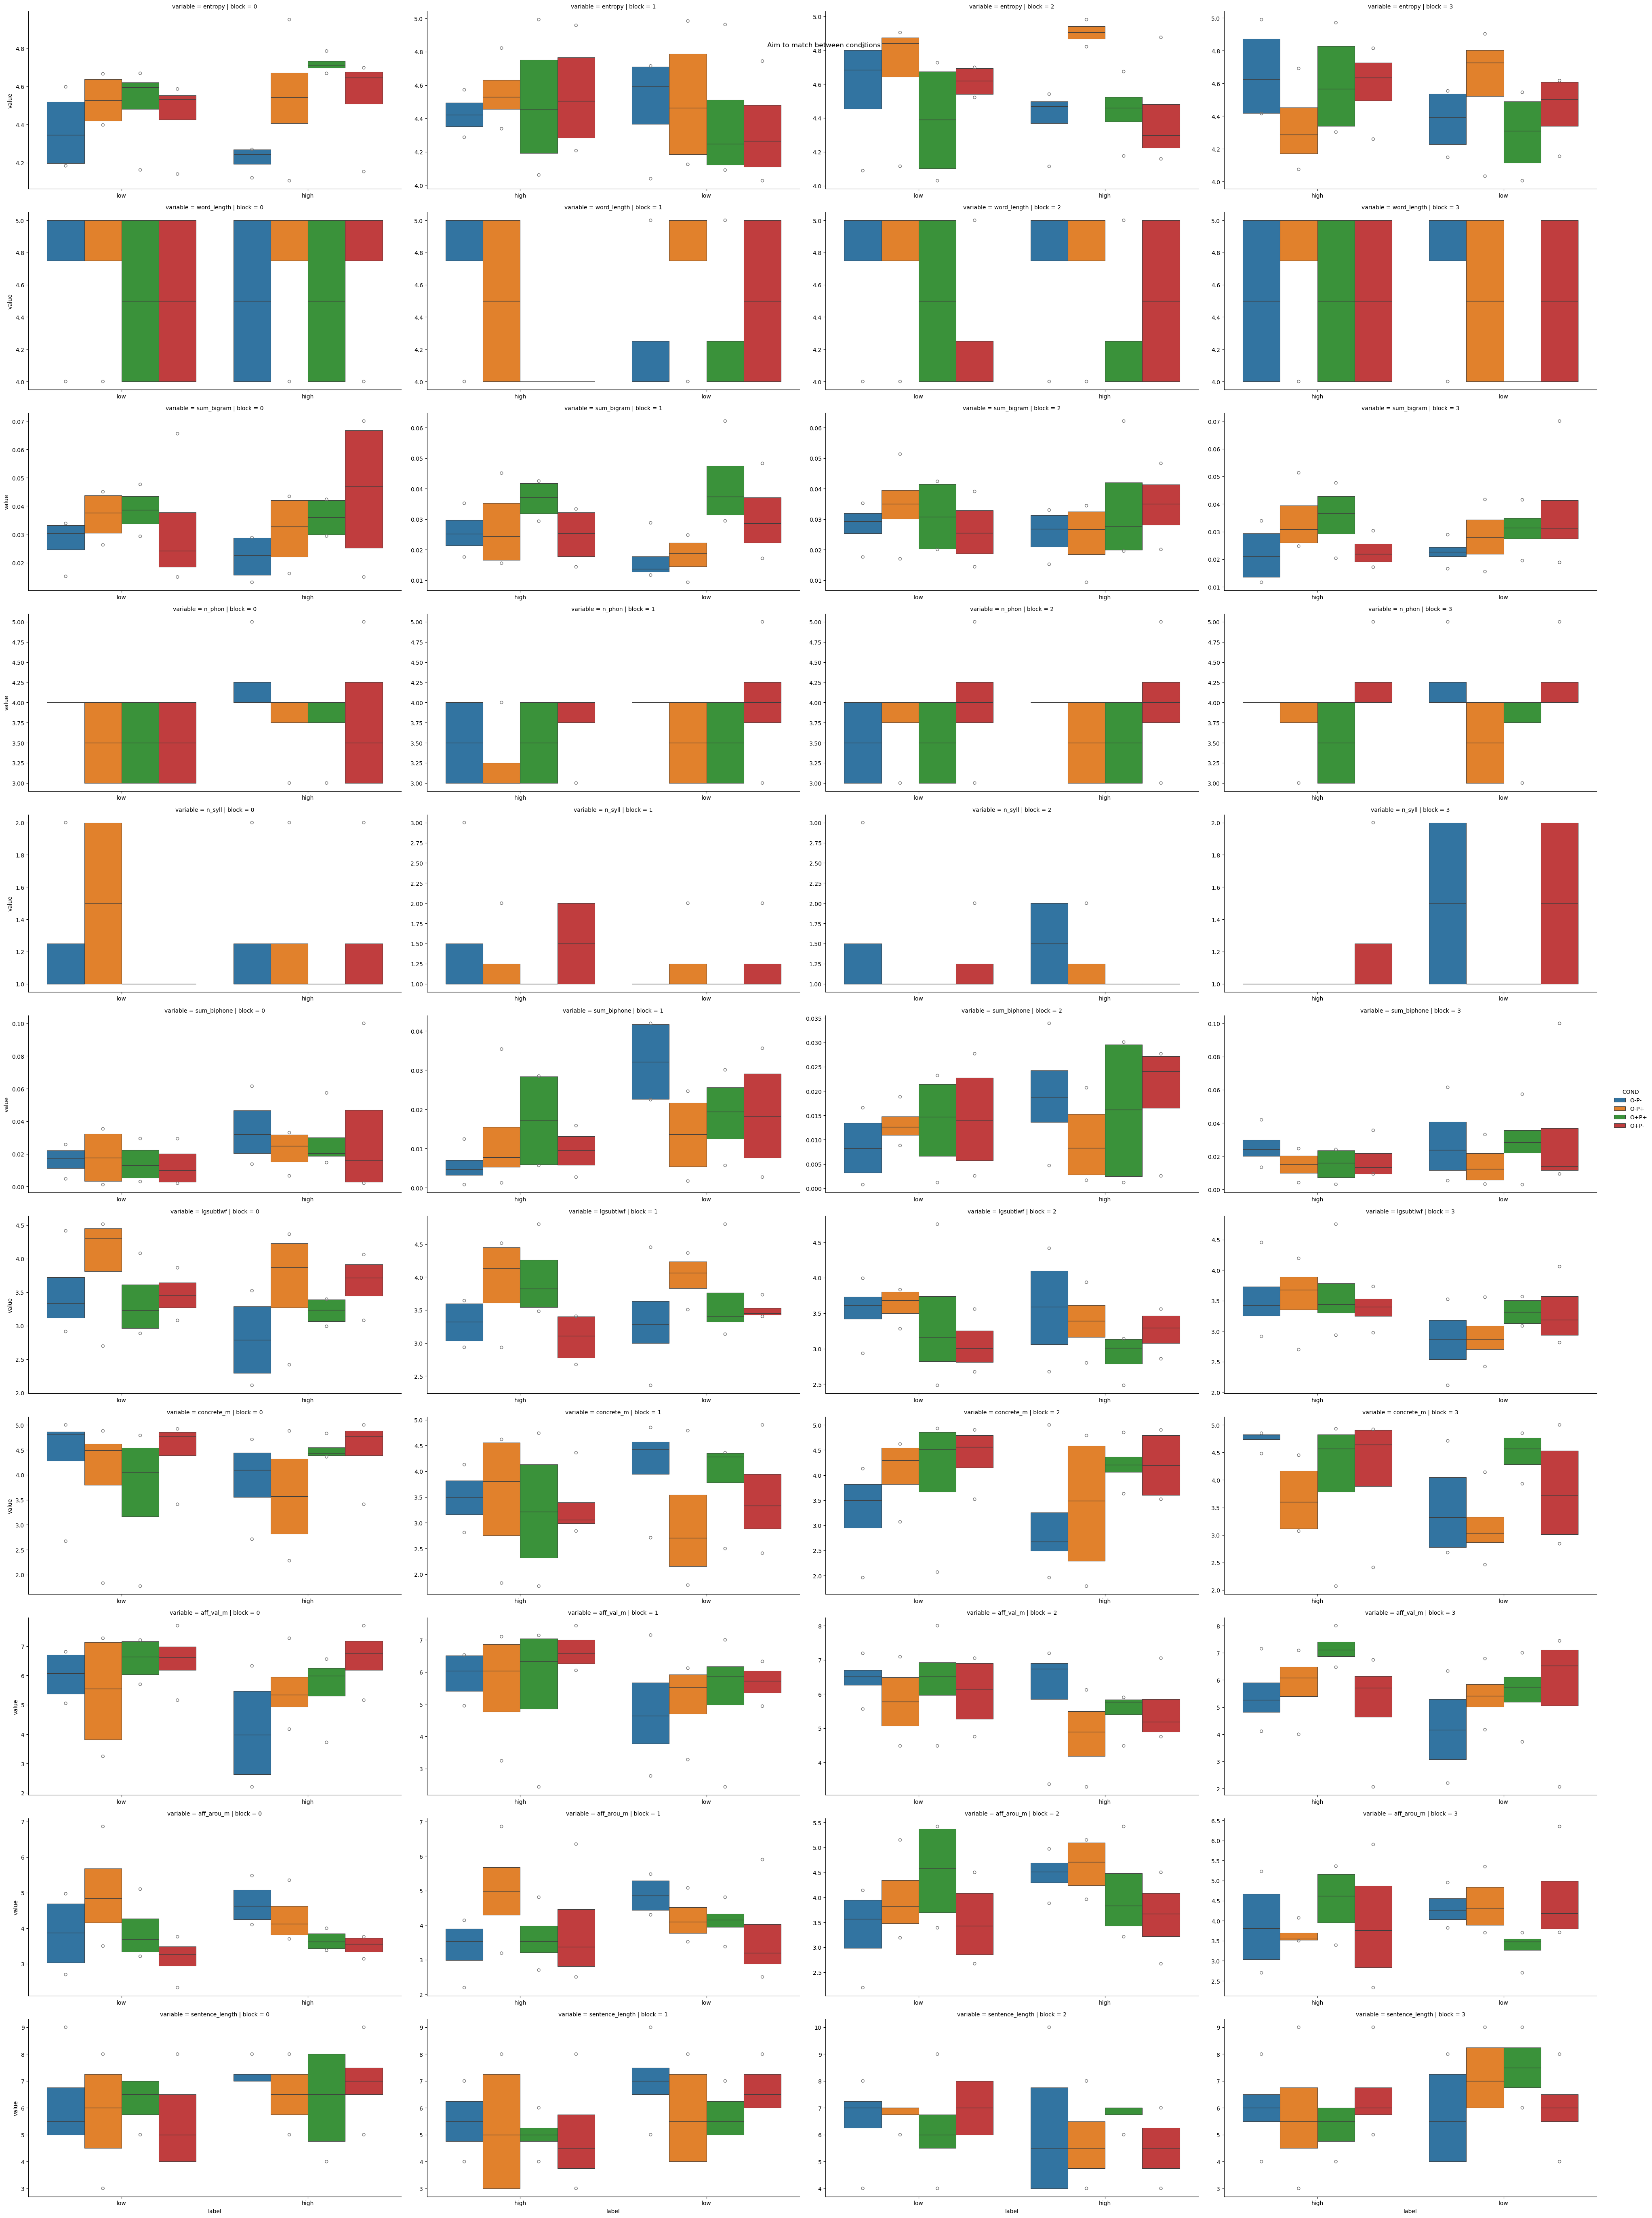

In [239]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(min_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Aim to match between conditions")

Text(0.5, 0.98, 'Other stuff')

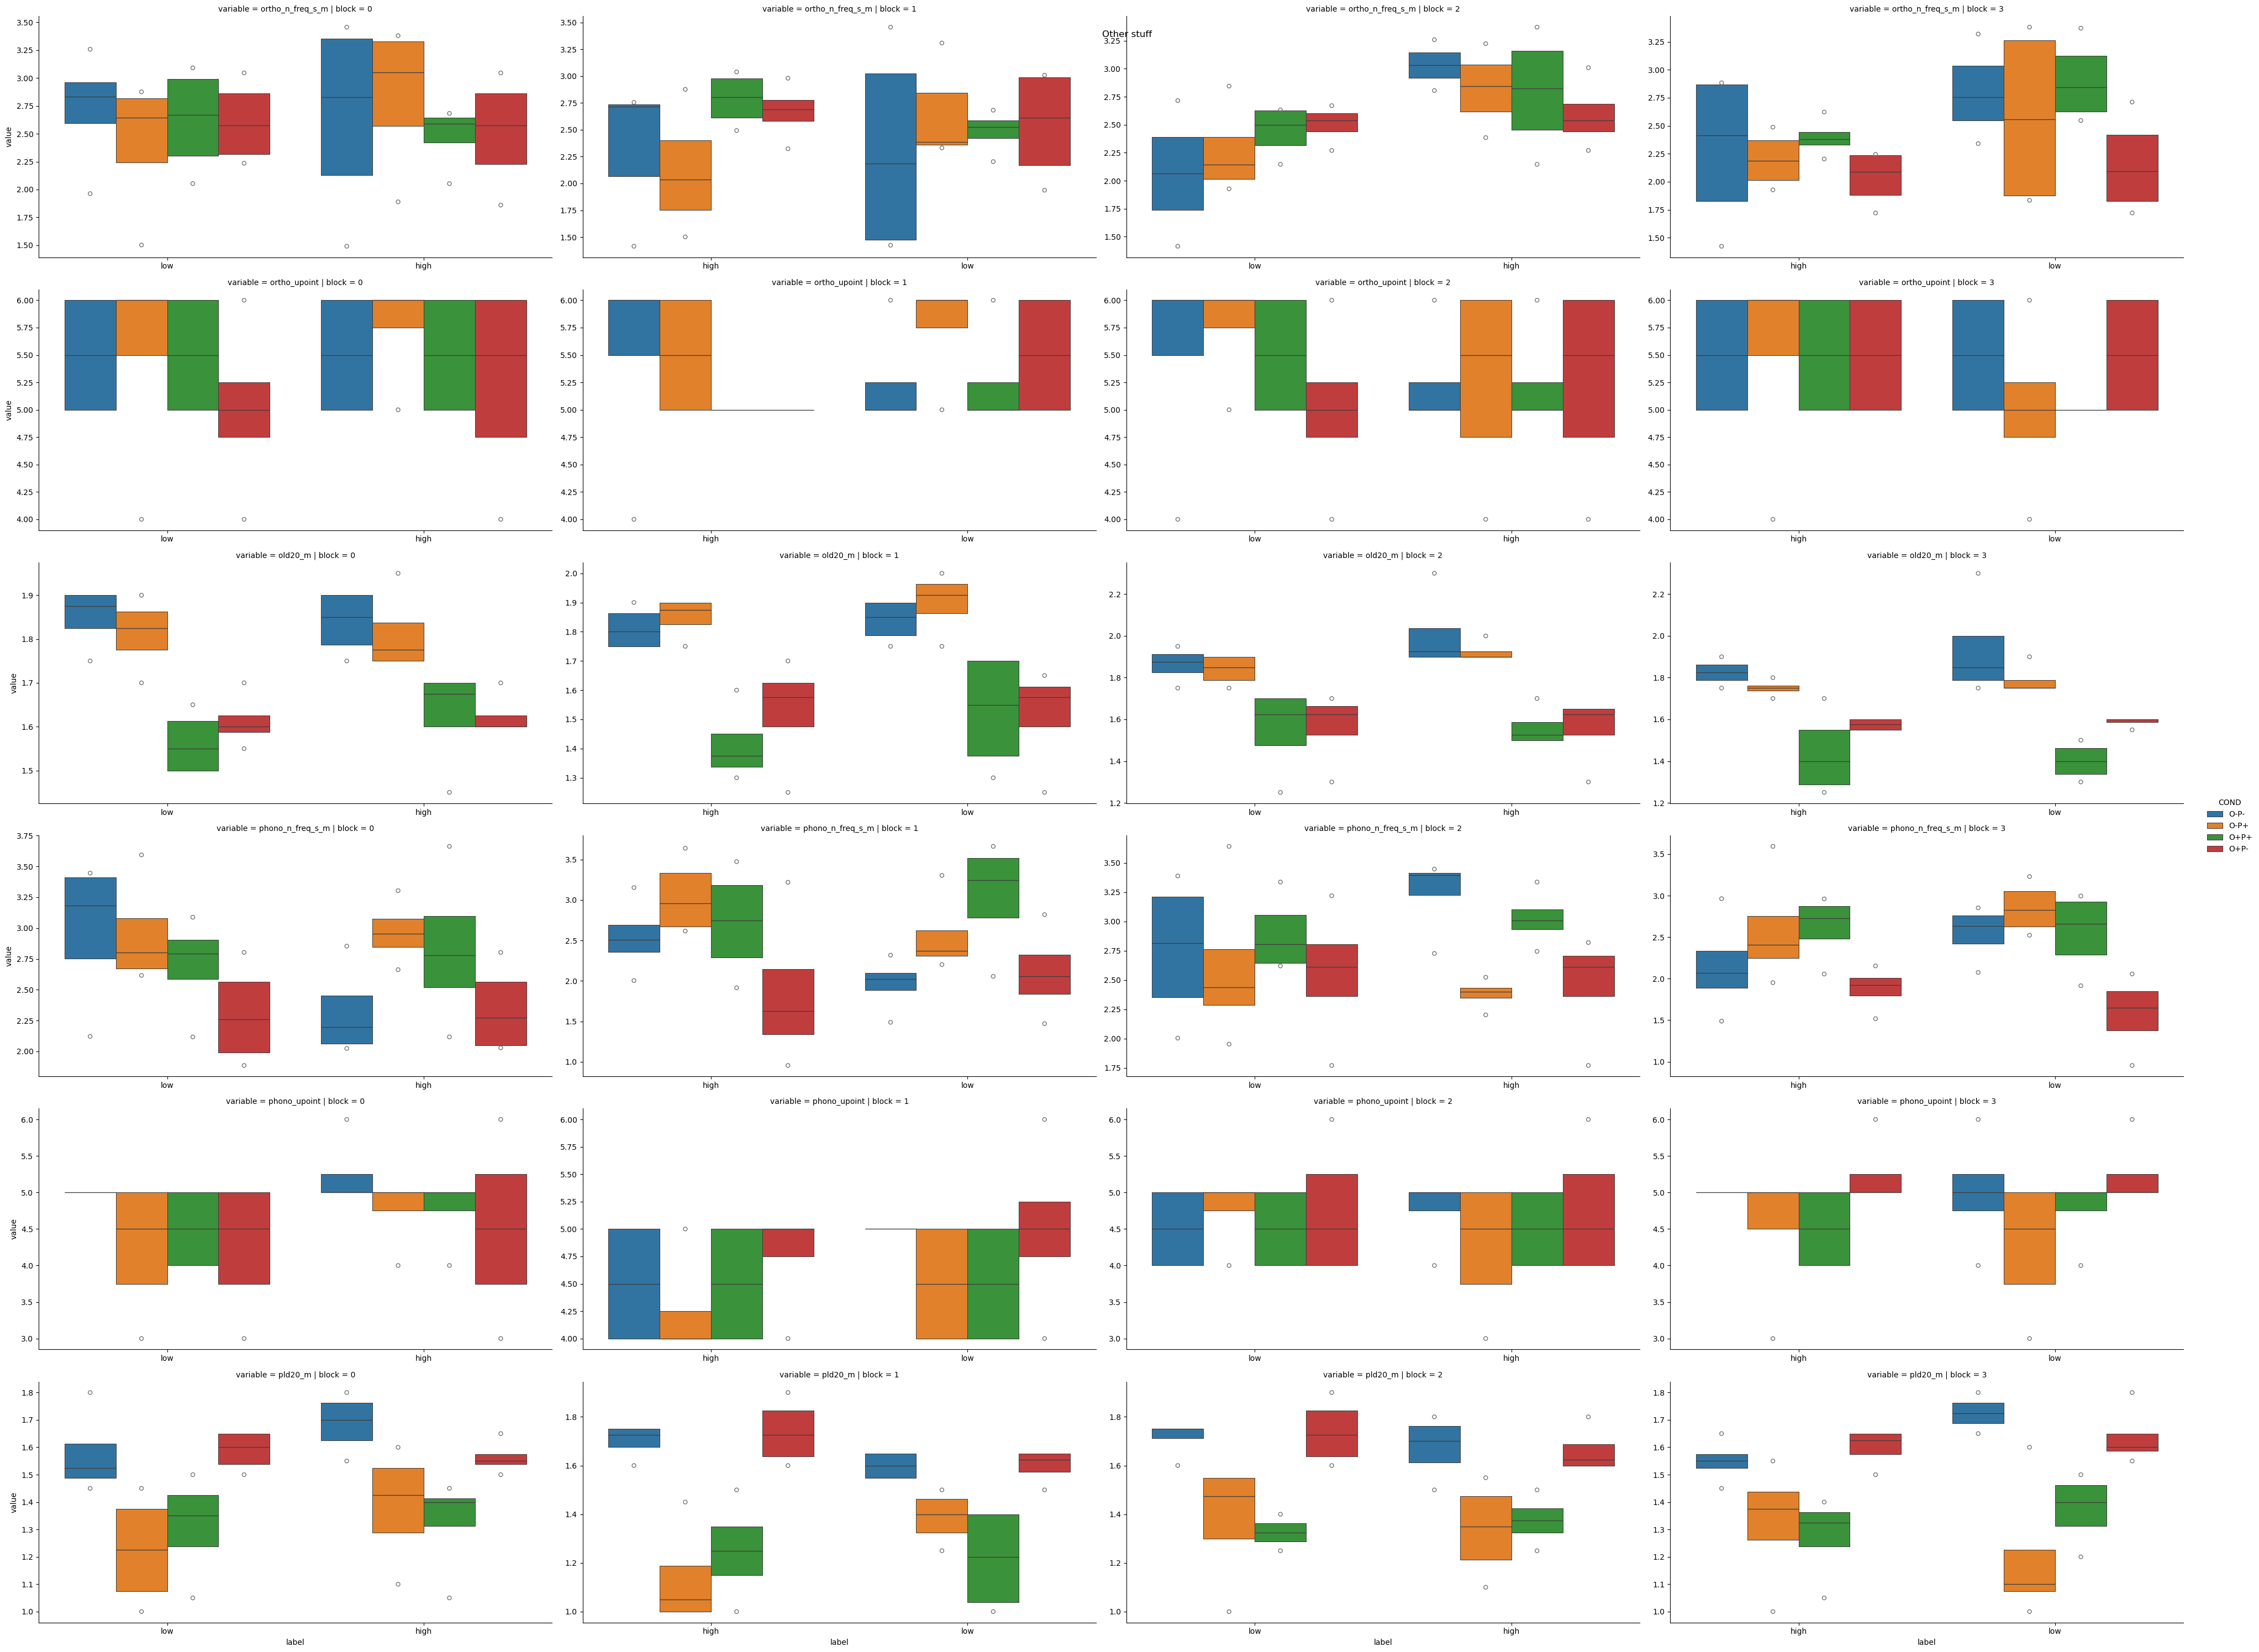

In [240]:
g = sns.catplot(data=s_melted[~s_melted.variable.isin(min_variables + max_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Other stuff")